In [1]:
from typing import TypedDict, List

from langchain.chains import RetrievalQA
from langgraph.graph import StateGraph, END
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings, OllamaLLM

**Dokument wejściowy**.

In [2]:
text = """
Warszawa jest miastem w centralnej Polsce. Kraków był dawną stolicą Polski i jest znany z zabytków.
Gdańsk leży nad Morzem Bałtyckim. Wrocław słynie z mostów i krasnali.
Pałac Namiestnikowski, będacy siedziba prezydenta RP, mieści się w Warszawie.
Poznań jest znany z koziołków.
Prezydent kraju urzęduje w stolicy.
"""

Podział dokumentów na fragmenty.

In [3]:
splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=25)
docs = splitter.create_documents([text])

In [4]:
docs

[Document(metadata={}, page_content='Warszawa jest miastem w centralnej Polsce. Kraków był dawną stolicą Polski i jest znany z zabytków.'),
 Document(metadata={}, page_content='Gdańsk leży nad Morzem Bałtyckim. Wrocław słynie z mostów i krasnali.'),
 Document(metadata={}, page_content='Pałac Namiestnikowski, będacy siedziba prezydenta RP, mieści się w Warszawie.'),
 Document(metadata={}, page_content='Poznań jest znany z koziołków.\nPrezydent kraju urzęduje w stolicy.')]

Tworzymy embeddingi przez Ollama.

In [5]:
embeddings = OllamaEmbeddings(model="phi4")

Tworzymy bazę Chroma.

In [6]:
db = Chroma.from_documents(docs, embeddings)

Definiujemy `retriever`.

In [7]:
retriever = db.as_retriever()

Definiujemy model, który będzie służył do obsługi `pipeline`.

In [8]:
llm = OllamaLLM(model="phi4")

# Stan w grafie.

In [9]:
class GraphState(TypedDict):
    question: str
    queries: list[str]
    documents: list[str]
    answer: str
    answer_pl: str

In [10]:
state = GraphState(
    question="Jakie miasto jest stolica Polski?"
)

In [11]:
state

{'question': 'Jakie miasto jest stolica Polski?'}

# Węzły LangGraph.

Pytanie od użytkownika.

In [12]:
def get_user_question(state: GraphState) -> GraphState:
    return state

Generowanie 5 alternatywnych zapytań.

In [13]:
def generate_queries(state: GraphState) -> GraphState:
    question = state["question"]
    prompt = f"""
        Wygeneruj 5 różnych, precyzyjnych zapytań, które pomogą znaleźć informacje dla pytania:
        \n\n\
        "{question}"
        \n\n
        Oddziel każde zapytanie znakiem ###
    """
    response = llm.invoke(prompt)
    queries = [q.strip() for q in response.split("###") if q.strip()]
    return {**state, "queries": queries[:5]}

In [14]:
state = generate_queries(state)

Wyszukiwanie dokumentów dla każdej kwerendy.

In [15]:
def multi_retrieve(state: GraphState) -> GraphState:
    docs = list()
    for q in state["queries"]:
        result = retriever.invoke(q)
        docs.extend(result)
    # Usunięcie duplikatów i ekstrakcja tekstu.
    unique = list({d.page_content for d in docs})
    return {**state, "documents": unique}

In [16]:
state = multi_retrieve(state)

In [17]:
state

{'question': 'Jakie miasto jest stolica Polski?',
 'queries': ['1. Jaka jest oficjalna stolica Republiki Polskiej?',
  '2. W którym mieście znajduje się główny skład rządu polskiego?',
  '3. Gdzie są zlokalizowane najważniejsze instytucje państwowe i dyplomatyczne w Polsce?',
  '4. Jakie miasto jest centrum życia politycznego oraz kulturalnym sercem Polski?',
  '5. W jaki sposób zostało wybrane stolice Polski podczas powstania niepodległej państwa po I wojnie światowej?'],
 'documents': ['Warszawa jest miastem w centralnej Polsce. Kraków był dawną stolicą Polski i jest znany z zabytków.',
  'Gdańsk leży nad Morzem Bałtyckim. Wrocław słynie z mostów i krasnali.',
  'Pałac Namiestnikowski, będacy siedziba prezydenta RP, mieści się w Warszawie.',
  'Poznań jest znany z koziołków.\nPrezydent kraju urzęduje w stolicy.']}

Generowanie odpowiedzi i prezentowanie kontekstu.

In [18]:
def generate_final_answer(state: GraphState) -> GraphState:
    question = state["question"]
    context = "\n".join(state["documents"])
    prompt = f"""Na podstawie poniższego kontekstu,
    odpowiedz na pytanie:

Kontekst:
{context}

Pytanie:
{question}

"""
    answer = llm.invoke(prompt)
    return {**state, "answer": answer}

Zadbaj o poprawność gramatyczna i dobierz odpowiednie słownictwo przygotowujac odpowiedź w języku polskim.

In [25]:
def fix_grammar(state: GraphState) -> GraphState:
    answer = state["answer"]
    prompt = f"""Zastanów się, czy możesz poprawić poprawność gramatyczna i słownictwo
    modyfikujac odpowiedz, która przygotowałeś, tak, aby była napisana doskonała polszczyzna.

    Twoja odpowiedz:
    
    {answer}

    Zwróć wyłacznie treść poprawionej odpowiedzi.
    """
    answer_pl = llm.invoke(prompt)
    return {**state, "answer_pl": answer_pl}

In [26]:
graph = StateGraph(GraphState)

graph.add_node("get_question", get_user_question)
graph.add_node("generate_queries", generate_queries)
graph.add_node("multi_retrieve", multi_retrieve)
graph.add_node("generate_answer", generate_final_answer)
graph.add_node("fix_grammar", fix_grammar)

graph.set_entry_point("get_question")
graph.add_edge("get_question", "generate_queries")
graph.add_edge("generate_queries", "multi_retrieve")
graph.add_edge("multi_retrieve", "generate_answer")
graph.add_edge("generate_answer", "fix_grammar")
graph.add_edge("fix_grammar", END)

rag_graph = graph.compile()

Wizualizacja grafu.

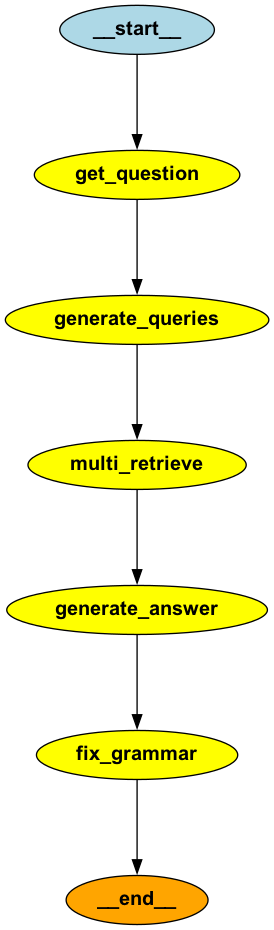

In [27]:
from IPython.display import Image

rag_graph.get_graph().draw_png("graph.png")

Image("graph.png")

Uruchomienie przepływu.

In [28]:
question = """
    Czy na podstawie informacji, które otrzymałeś, jesteś w stanie stwierdzić,
    czy prezydent kraju urzęduje w jego stolicy? Jeśli tak, to jakie miasto jest
    stolica Polski? Jeśli nie, to poinformuj, że nie masz wystarczajcych informacji,
    aby odpowiedzieć na to pytanie. Przedstaw swój tok rozumowania.
"""

result = rag_graph.invoke({"question": question})

In [29]:
print(result["answer"])

Na podstawie dostarczonego kontekstu można stwierdzić kilka rzeczy dotyczących urzędu prezydenta i stolicy Polski:

1. Kontekst informuje, że "Pałac Namiestnikowski, będący siedzibą prezydenta RP, mieści się w Warszawie." Oznacza to, że obecna siedziba prezydenta Polski znajduje się w Warszawie.

2. Kontekst potwierdza również, że "Prezydent kraju urzęduje w stolicy."

Biorąc pod uwagę te dwie informacje, można doszedł do wniosku:
- Ponieważ prezydent Polski urzęduje w stolicy i Pałac Namiestnikowski (siedziba prezydenta) znajduje się w Warszawie, to miejsce, gdzie prezydent urzęduje, musi być stolicą kraju.

3. Dodatkowo kontekst nie wymienia żadnych innych miast jako obecnej stolicy Polski poza Warszawą, chociaż wspomina o historycznym znaczeniu Krakowa jako dawnej stolicy.

Zatem, na podstawie dostępnych informacji można z pewnością stwierdzić, że prezydent kraju urzęduje w jego stolicy, a to miasto to Warszawa. Zatem Warszawa jest stolicą Polski.
